In [39]:
%matplotlib inline

In [40]:
import numpy as np
import scipy
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Initialize functions

###a. Simulation - resampling

In [41]:
def sim_CCC_IFE(mouse_ID, clone_distribution_IFE, clone_distribution_HF, colors_IFE, colors_HF, iterations):
    
    """
    
    Bootstrapping function to randomly resample empirical data in order to simulate the distribution of correlated, 
    non-correlated and unlabelled clones in each mouse under the assumption that IFE and PSU are independent.
    
    ----------
    mouse_ID: [list] of mice / experiments from which the empirical data used for the simulation is derived.
    
    clone_distribution_IFE: [DataFrame] containing IFE clone distribution for each mouse. Indices must be mouse IDs, 
    columns must be clones per IFE.
    
    clone_distribution_HF: [DataFrame] containing HF clone distribution for each mouse (not divided by number of HFs!). 
    Indices must be mouse IDs, columns must be number of HF clones in analysed region.
    
    colors_IFE: [DataFrame] containing IFE color distribution for each mouse. Indices must be mouse IDs, 
    columns must be number of IFE clones which are 'B', 'G', 'Y', 'R'.
    
    colors_IST: [DataFrame] containing HF color distribution for each mouse. Indices must be mouse IDs, 
    columns must be number of HF clones which are 'B', 'G', 'Y', 'R'.
    
    ----------
    
    returns [DataFrame] containing the fraction of correlated, non-correlated and non labelled clones over 
    each iteration in each mouse
    
    """
    
    #initialize output file
    
    ix1, ix2 = [], []
    
    for it in range(iterations):
        ix1 += [it] * 3
        ix2 += ['no_label','non_corr','corr']
    
    output = pd.DataFrame(index = [ix1, ix2], columns = mouse_ID)
    
    #initialize IFE clone distributions for np.random.choice
    
    clones_choice_IFE = {}
    
    for mouse in clone_distribution_IFE.index:
        tmp = []
        
        for clones_per_IFE in clone_distribution_IFE.columns:
            tmp += [clones_per_IFE] * clone_distribution_IFE.ix[mouse, clones_per_IFE]
            
        clones_choice_IFE[mouse] = tmp
    
    #initialize HF clone distributions for np.random.choice
    
    clones_choice_HF = {}
    
    for mouse in clone_distribution_HF.index:
        tmp = []
        
        for clones_per_HF in clone_distribution_HF.columns:
            tmp += [clones_per_HF] * clone_distribution_HF.ix[mouse, clones_per_HF]
            
        clones_choice_HF[mouse] = tmp
        
    #initialize IFE color distribution for np.random.choice
    
    colors_choice_IFE = {}
    
    for mouse in colors_IFE.index:
        tmp = []
        
        for color in colors_IFE.columns:
            tmp += [color] * colors_IFE.ix[mouse, color]
            
        colors_choice_IFE[mouse] = tmp
        
    #initialize HF color distribution for np.random.choice
    
    colors_choice_HF = {}
    
    for mouse in colors_HF.index:
        tmp = []
        
        for color in colors_HF.columns:
            tmp += [color] * colors_HF.ix[mouse, color]
            
        colors_choice_HF[mouse] = tmp
        
    #iterate over simulation repeats
    
    for it in range(iterations):
        
        #iterate over mice
        
        for mouse in mouse_ID:
            
            #initialize count
            
            no_label_tmp = 0
            non_corr_tmp = 0
            corr_tmp = 0
            
            #iterate of number of regions (based on IFE clones) that were counted per mouse 
            
            for region in range(len(clones_choice_IFE[mouse])):
                
                #chose number of IFE clones and their colors
                
                c_IFE = np.random.choice(colors_choice_IFE[mouse], np.random.choice(clones_choice_IFE[mouse], 1))
                
                #chose number of HF clones and their colors
                
                c_HF = np.random.choice(colors_choice_HF[mouse], np.random.choice(clones_choice_HF[mouse], 1))
                
                #score
                                        
                for c_IFE_tmp in set(c_IFE):
                    
                    if len(c_HF) == 0:
                        no_label_tmp += 1
                        
                    elif c_IFE_tmp not in c_HF:
                        non_corr_tmp += 1
                            
                    elif c_IFE_tmp in c_HF:
                        corr_tmp += 1
                    
            #update output
            
            output.ix[it, 'no_label'][mouse] = float(no_label_tmp) / float(no_label_tmp + non_corr_tmp + corr_tmp)
            output.ix[it, 'non_corr'][mouse] = float(non_corr_tmp) / float(no_label_tmp + non_corr_tmp + corr_tmp)
            output.ix[it, 'corr'][mouse] = float(corr_tmp) / float(no_label_tmp + non_corr_tmp + corr_tmp)
            
    return output

###b. Drawing

In [42]:
def draw_sim_CCC(sim_results, emp_results = None):
    
    """
    
    Draws resampling results as violin plots and superimposes empirical results
    
    ----------
    
    sim_results: [DataFrame] containing the fraction of correlated, non-correlated and non labelled clones over 
    each iteration in each mouse
    
    emp_results; [DataFrame] containing the empirically determined fractions of correlated, non-correlated and 
    non labelled clones in each mouse.
    
    """
    
    #create figure
    
    fig = plt.figure(facecolor = 'w', figsize = (20,10))
    ax = plt.axes()
    
    #create xaxis
    
    ax.set_xlim(0, len(sim_results.columns))
    
    xticks = []
    
    for ix in range(len(sim_results.columns)):
        xticks += [ix + 0.25, ix + 0.5, ix + 0.75]
        
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    
    #create yaxis
    
    ax.set_ylim(0,1)
    
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], family = 'Arial', fontsize = 30)
    
    ax.set_ylabel('Probability', family = 'Arial', fontsize = 35)
    
    #create position and colormap
    
    posmap = {'no_label':0.25,
               'non_corr':0.5,
               'corr':0.75}
    
    cmap = {'no_label':'blue',
             'non_corr':'green',
             'corr':'red'}
    
    #plot data
    
    for pos, mouse in enumerate(sim_results.columns):
        
        #draw text
        
        ax.text(pos + 0.5, -0.05, mouse, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
                
        for x in ['no_label','non_corr','corr']:
            
            #draw violin plots
            
            if np.sum([val for val in sim_results.swaplevel(0,1).ix[x][mouse].values]) == 0:
                continue
                
            else:
                
                q_5 = np.percentile(sim_results.swaplevel(0,1).ix[x][mouse].values, 5)
                q_95 = np.percentile(sim_results.swaplevel(0,1).ix[x][mouse].values, 95)
                violin_tmp = [val for val in sim_results.swaplevel(0,1).ix[x][mouse].values if val >= q_5 and val <= q_95]
                
                violin = ax.violinplot(violin_tmp,
                                       positions = [pos + posmap[x]],
                                       showextrema = False, widths = 0.25)

                for v in violin['bodies']:

                    v.set_edgecolor(cmap[x])
                    v.set_facecolor(cmap[x])
                    v.set_linewidth(1.0)
                    v.set_alpha(0.25)
                    
                ax.plot([pos + posmap[x] - 0.05, pos + posmap[x] + 0.05],[q_5, q_5], color = cmap[x], linewidth = 3)
                ax.plot([pos + posmap[x] - 0.05, pos + posmap[x] + 0.05],[q_95, q_95], color = cmap[x], linewidth = 3)

            #draw empirical data
            
            try:
                ax.scatter(pos + posmap[x],
                           [emp_results.ix[mouse, x]], 
                           color = cmap[x],
                           edgecolor = cmap[x], 
                           s=100)
            except:
                continue

#2. Load data

In [43]:
mouse_ID = ['AS30:5','AS30:7','AS29:9','AS25:1','AS42:3','AS55:1','AS57:1','AS51:4','AS55:3']

In [44]:
clones_per_HF_emp = pd.DataFrame(index = ['AS29:9','AS25:1'], columns = range(11))

clones_per_HF_emp.ix['AS30:5'] = [12,7,8,2,1,1,0,0,0,1,0]
clones_per_HF_emp.ix['AS30:7'] = [12,2,2,1,0,0,0,0,0,0,0]
clones_per_HF_emp.ix['AS29:9'] = [0,4,7,2,1,1,1,0,0,0,0]
clones_per_HF_emp.ix['AS25:1'] = [0,26,5,1,1,0,0,0,0,0,0]
clones_per_HF_emp.ix['AS42:3'] = [4,3,2,2,2,0,1,1,0,0,2]
clones_per_HF_emp.ix['AS55:1'] = [5,3,1,2,0,1,0,0,0,0,0]
clones_per_HF_emp.ix['AS57:1'] = [5,4,1,0,0,0,0,0,0,0,0]
clones_per_HF_emp.ix['AS51:4'] = [20,5,2,2,0,0,0,0,0,0,0]
clones_per_HF_emp.ix['AS55:3'] = [17,4,0,0,0,0,0,0,0,0,0]

In [45]:
clones_per_HF_emp.ix['AS30:5'][0]/np.sum(clones_per_HF_emp.ix['AS30:5'])

0.375

In [46]:
clones_per_IFE_emp = pd.DataFrame(index = ['AS29:9','AS25:1'], columns = range(11))

clones_per_IFE_emp.ix['AS30:5'] = [0,20,6,4,1,1,0,0,0,0,0]
clones_per_IFE_emp.ix['AS30:7'] = [0,12,5,0,0,0,0,0,0,0,0]
clones_per_IFE_emp.ix['AS29:9'] = [4,4,3,2,9,0,1,2,0,0,0]
clones_per_IFE_emp.ix['AS25:1'] = [5,6,6,5,6,2,0,0,1,0,1]
clones_per_IFE_emp.ix['AS42:3'] = [0,13,3,1,0,0,0,0,0,0,0]
clones_per_IFE_emp.ix['AS55:1'] = [0,6,5,1,0,0,0,0,0,0,0]
clones_per_IFE_emp.ix['AS57:1'] = [0,8,1,1,0,0,0,0,0,0,0]
clones_per_IFE_emp.ix['AS51:4'] = [0,22,8,0,0,0,0,0,0,0,0]
clones_per_IFE_emp.ix['AS55:3'] = [0,17,4,0,0,0,0,0,0,0,0]

In [47]:
colors_per_mouse_HF_emp = pd.DataFrame(index = ['AS29:9','AS25:1'], 
                                       columns = ['R','Y','B','G'])

colors_per_mouse_HF_emp.ix['AS30:5'] = [23,21,2,1]
colors_per_mouse_HF_emp.ix['AS30:7'] = [4,4,0,0]
colors_per_mouse_HF_emp.ix['AS29:9'] = [15,13,2,9]
colors_per_mouse_HF_emp.ix['AS25:1'] = [31,7,0,19]
colors_per_mouse_HF_emp.ix['AS42:3'] = [17,14,1,17]
colors_per_mouse_HF_emp.ix['AS55:1'] = [4,11,0,1]
colors_per_mouse_HF_emp.ix['AS57:1'] = [4,1,0,1]
colors_per_mouse_HF_emp.ix['AS51:4'] = [7,7,0,2]
colors_per_mouse_HF_emp.ix['AS55:3'] = [3,1,0,0]

In [48]:
colors_per_mouse_IFE_emp = pd.DataFrame(index = ['AS29:9','AS25:1'], 
                                       columns = ['R','Y','B','G'])

colors_per_mouse_IFE_emp.ix['AS30:5'] = [31,17,5,0]
colors_per_mouse_IFE_emp.ix['AS30:7'] = [12,10,0,0]
colors_per_mouse_IFE_emp.ix['AS29:9'] = [12,9,8,7]
colors_per_mouse_IFE_emp.ix['AS25:1'] = [51,24,11,16]
colors_per_mouse_IFE_emp.ix['AS42:3'] = [11,5,0,6]
colors_per_mouse_IFE_emp.ix['AS55:1'] = [7,9,2,1]
colors_per_mouse_IFE_emp.ix['AS57:1'] = [5,4,1,3]
colors_per_mouse_IFE_emp.ix['AS51:4'] = [21,16,1,0]
colors_per_mouse_IFE_emp.ix['AS55:3'] = [5,18,2,0]

In [49]:
iterations = 1000

In [50]:
emp_results = pd.DataFrame(index = ['AS29:9','AS25:1'],
                           columns = ['corr','non_corr','no_label'])

emp_results.ix['AS30:5'] = [0.395348837,0.139534884,0.465116279]
emp_results.ix['AS30:7'] = [0.227272727,0.045454545,0.727272727]
emp_results.ix['AS29:9'] = [0.44,0.56,0]
emp_results.ix['AS25:1'] = [0.380952381,0.619047619,0]
emp_results.ix['AS42:3'] = [0.636363636,0.181818182,0.181818182]
emp_results.ix['AS55:1'] = [0.263157895,0.157894737,0.578947368]
emp_results.ix['AS57:1'] = [0.384615385,0.230769231,0.384615385]
emp_results.ix['AS51:4'] = [0.157894737,0.078947368,0.763157895]
emp_results.ix['AS55:3'] = [0.08,0.04,0.88]

#3. Simulate and draw

In [51]:
sim_results = sim_CCC_IFE(mouse_ID,
                         clones_per_IFE_emp,
                         clones_per_HF_emp, 
                         colors_per_mouse_IFE_emp, 
                         colors_per_mouse_HF_emp, 
                         iterations)

In [52]:
mice_sel = ['AS30:5','AS30:7','AS42:3','AS55:1','AS51:4','AS55:3']

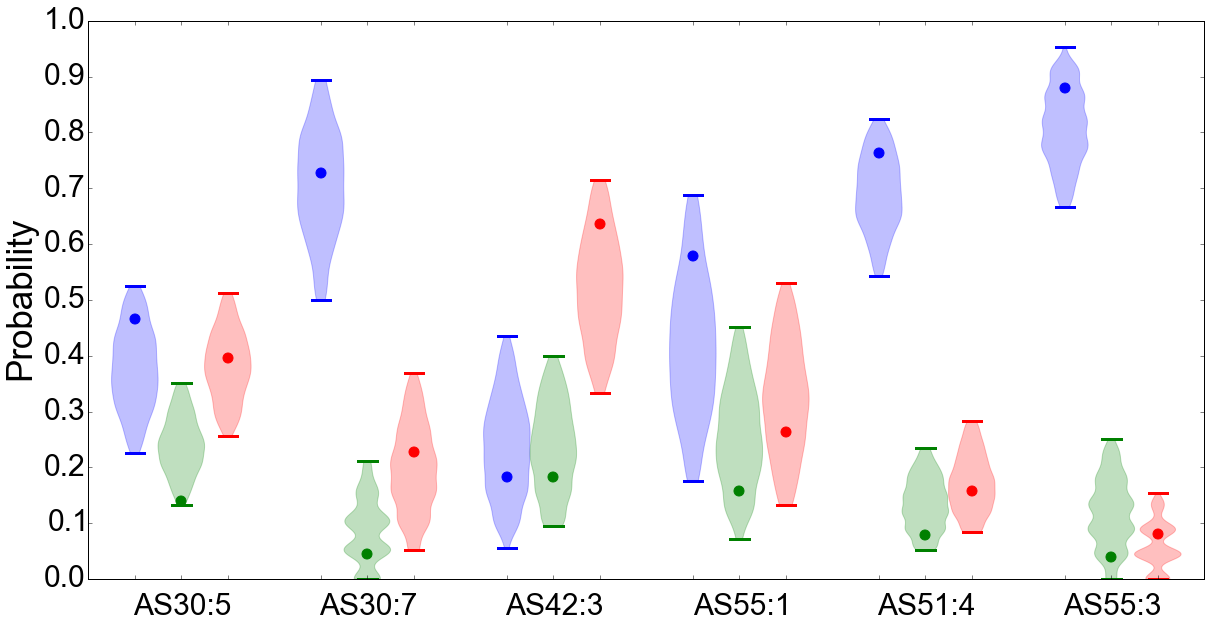

In [53]:
draw_sim_CCC(sim_results[mice_sel], emp_results = emp_results)

#5. P-values (probability that a correlation probability equal to or more extreme than the empirically observed is reached if the null hypothesis [no correlation] is true)

In [54]:
def get_pvalue_corr(sim_results, emp_results):
    
    #create output
    
    output = pd.Series(index = sim_results.columns)
    
    #iterate over mice
    
    for mouse in sim_results.columns:
        
        null_distr_tmp = sim_results.swaplevel(0,1).ix['corr'][mouse]
        
        emp_tmp = emp_results.ix[mouse, 'corr']
        
        p_tmp = float(np.sum(null_distr_tmp > emp_tmp)) / len(null_distr_tmp)
        
        output[mouse] = p_tmp
        
    return output

In [58]:
print get_pvalue_corr(sim_results[mice_sel], emp_results)

AS30:5    0.432
AS30:7    0.358
AS42:3    0.164
AS55:1    0.673
AS51:4    0.550
AS55:3    0.433
dtype: float64
